### https://github.com/ewenme/transfers/blob/master/src/functions.R

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
from highlight_text import fig_text
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mplsoccer import FontManager
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

from pathlib import Path
import urllib

from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image # image

from PIL import Image
from metadata import convert_nation_dict

In [5]:
dfs = []
urls = [
    "https://www.transfermarkt.com/transfers/endendevertraege/statistik?jahr=2023&land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle",
    "https://www.transfermarkt.com/transfers/endendevertraege/statistik?jahr=2023&land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&page=2",
    "https://www.transfermarkt.com/transfers/endendevertraege/statistik?jahr=2023&land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&page=3"
]
for url in urls:
    page = requests.get(url, headers={'User-Agent': 'Custom'})

    soup = BeautifulSoup(page.content, "html.parser")

    table = soup.find(class_="grid-view", id="yw1")

    table_body = table.find('tbody')
    rows = table_body.find_all('tr')

    player_names = []
    player_nations = []
    player_clubs = []
    player_positions = []
    player_current_values = []
    player_previous_values = []
    for i in np.arange(0,len(rows),5):
        player_names.append(rows[i].a.attrs.get("title"))
        player_nations.append(rows[i].find_all("img")[1].attrs.get("title"))
        player_clubs.append(rows[i].find_all("a")[1].attrs.get("title"))
        player_positions.append(rows[i].find_all("td")[3].text)
        player_current_values.append(rows[i].find("td", class_="rechts").text.split()[0])
        player_previous_values.append(rows[i].find("td", class_="rechts").span.attrs.get("title").split(" ")[-1])

    df = pd.DataFrame({
        "Name":player_names, "Nation":player_nations, "Club":player_clubs, "Position":player_positions, 
        "Current_value":player_current_values, "Previous_value":player_previous_values
    })   
    dfs.append(df)


In [6]:
df = pd.concat(dfs)
df.replace(convert_nation_dict, inplace=True)

flag_paths = list(Path("/work/assets/country_flags").glob("*.png"))
country_to_flagpath = {p.stem: p for p in flag_paths}

df.insert(0, "Flag", df["Nation"].apply(lambda x: country_to_flagpath.get(x)))

In [7]:
df["Club"].unique()

array(['Inter Milan', 'Paris Saint-Germain', 'Leicester City',
       'Real Madrid', 'Crystal Palace', 'Borussia Mönchengladbach',
       'Eintracht Frankfurt', 'Chelsea FC', 'Liverpool FC', 'RB Leipzig',
       'Manchester City', 'Juventus FC', 'SL Benfica',
       'Borussia Dortmund', 'LOSC Lille', 'Olympique Lyon',
       'Athletic Bilbao', 'Wolverhampton Wanderers', 'Everton FC',
       'Blackburn Rovers', 'Manchester United', 'AS Roma',
       'AFC Bournemouth', 'Nottingham Forest', 'Rangers FC', '1. FC Köln',
       'Fenerbahce', 'Tottenham Hotspur', 'Atlético de Madrid',
       'Southampton FC', 'Besiktas JK', 'Brighton & Hove Albion',
       'OGC Nice', 'West Ham United', 'Ajax Amsterdam', 'FC Porto',
       'Getafe CF', 'Zenit St. Petersburg', 'Stade Rennais FC',
       'Olympiacos Piraeus', 'TSG 1899 Hoffenheim', 'Al-Duhail SC',
       '1.FC Union Berlin', 'Sporting CP', 'RC Strasbourg Alsace',
       'FC Shabab Al-Ahli Dubai', 'Rayo Vallecano', 'FC Toulouse',
       '1.FSV M

In [12]:
squad_name = [
    # Liga
    'FC Barcelona', 'Real Madrid', 'Atlético de Madrid', 'Real Sociedad',
    'Athletic Club', 'Real Betis Balompié', 'Villarreal CF', 'Rayo Vallecano',
    'Osasuna', 'Mallorca', 'Valencia', 'Girona FC',
    'Getafe CF', 'Almería', 'Valladolid', 'Celta Vigo',
    'Sevilla FC', 'Cádiz', 'Espanyol', 'Elche',
    # Premier
    "Arsenal", "Manchester City", "Manchester United", "Crystal Palace",
    "West Ham United", "Aston Villa", "AFC Bournemouth","Leeds United",
    "Liverpool FC", "Brighton & Hove Albion", "Tottenham Hotspur", "Brentford FC",
    "Fulham FC", "Chelsea FC", "Newcastle Utd", "Wolverhampton Wanderers", 
    "Southampton FC", "Leicester City", 'Everton FC',
    # Seria
    "Napoli", "Inter Milan", "Juventus FC", 'AS Roma', 
    "AC Milan", "SS Lazio", "ACF Fiorentina", "Atalanta BC",
    # Ligue 1
    "Paris Saint-Germain", "Toulouse", "LOSC Lille", 'Olympique Lyon',
    "AS Monaco", 'Stade Rennais FC',
    # Bundes
    "Borussia Mönchengladbach", "Eintracht Frankfurt", "Borussia Dortmund",
    "RB Leipzig", "TSG 1899 Hoffenheim", 'Bayern Munich',
    "SC Freiburg",
    # Portgul
    'SL Benfica', 'FC Porto', 'Sporting CP',
    # Orange
    'Ajax Amsterdam',
    # Austria
    "Red Bull Salzburg"
]
squad_id = [
    # Liga
    '8634', '8633', '9906', '8560', 
    '8315', '8603', '10205', '8370', 
    '8371', '8661', '10267', '7732', 
    '8305', '9865', '10281', '9910', 
    '8302', '8385', '8558', "10268",
    # Premier
    '9825', '8456', '10260', '9826',
    '8654', '10252', '8678', '8463', 
    '8650', "10204", "8586", "9937",
    "9879", "8455", "10261", "8602",
    "8466", "8197", '8668',
    # Seria
    "9875", "8636", "9885", "8686", 
    "8564", "8543", "8535", "8524", 
    # Ligue 1
    "9847", "9941", "8639", "9748",
    "9829", "9851",
    # Bundes
    "9788", "9810", "9789", 
    "178475", "8226", "9823", 
    "8358",
    # Portgul
    '9772', "9773", "9768",
    # Oranje
    "8593",
    # Austria
    "10013",
]
# _squad = dict(zip(squad_name, squad_id))
df_fotmob_id = pd.DataFrame({"Squad":squad_name, "Squad_id":squad_id})
# df.to_csv("/work/assets/df_fotmob_id")

df = df.merge(df_fotmob_id, how="inner", left_on="Club", right_on="Squad")
df.shape

(54, 13)

In [13]:
COLS = ['Flag', 'Name', 'Squad_id', 
        'Position', 'Current_value','Previous_value']
df = df[COLS]
df["Squad_id"] = df["Squad_id"].astype(int)

In [14]:
cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="/usr/share/fonts/Nippo-Regular.ttf")
matplotlib.rcParams['font.family'] = font_prop.get_name()

col_defs = (
    [
        ColumnDefinition(
            name="index",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop },
            width=0.3,
        ),
        ColumnDefinition(
            name="Flag",
            title="Nation",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop },
            width=0.3,
            plot_fn=circled_image,
        ),
        ColumnDefinition(
            name="Name",
            title="Player",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop, "fontsize":17 },
            width=0.5,
        ),
        ColumnDefinition(
            name="Squad_id",
            title="Club",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop, "color":"white" },
            width=0.1,
        ),
        ColumnDefinition(
            name="Position",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop },
            width=0.5,
        ),
        ColumnDefinition(
            name="Current_value",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop },
            width=0.4,
        ),
        ColumnDefinition(
            name="Previous_value",
            textprops={"ha": "center", "weight": "bold", "fontproperties": font_prop },
            width=0.4,
        )
])

In [17]:
# data = df[COLS].sort_values(by=COLS[5], ascending=False).head(10)  
idx_start = 37
idx_end = len(df)
data = df.loc[idx_start:idx_end,:]
data.index = np.arange(idx_start+1, idx_start + len(data)+1)
data

,Flag,Name,Squad_id,Position,Current_value,Previous_value
38,/work/assets/country_flags/ENG.png,Tom Davies,8668,Central Midfield,€12.00m,€18.00m
39,/work/assets/country_flags/ESP.png,David de Gea,10260,Goalkeeper,€15.00m,€15.00m
40,/work/assets/country_flags/ITA.png,Andrea Belotti,8686,Centre-Forward,€15.00m,€20.00m
41,/work/assets/country_flags/ENG.png,Chris Smalling,8686,Centre-Back,€8.00m,€8.00m
42,/work/assets/country_flags/COL.png,Jefferson Lerma,8678,Defensive Midfield,€15.00m,€15.00m
43,/work/assets/country_flags/BRA.png,Lucas Moura,8586,Right Winger,€12.00m,€15.00m
44,/work/assets/country_flags/IRL.png,Matt Doherty,9906,Right-Back,€12.00m,€12.00m
45,/work/assets/country_flags/NOR.png,Mohamed Elyounoussi,8466,Left Winger,€12.00m,€12.00m
46,/work/assets/country_flags/NED.png,Joël Veltman,10204,Right-Back,€10.00m,€10.00m
47,/work/assets/country_flags/ARG.png,Manuel Lanzini,8654,Attacking Midfield,€10.00m,€12.00m


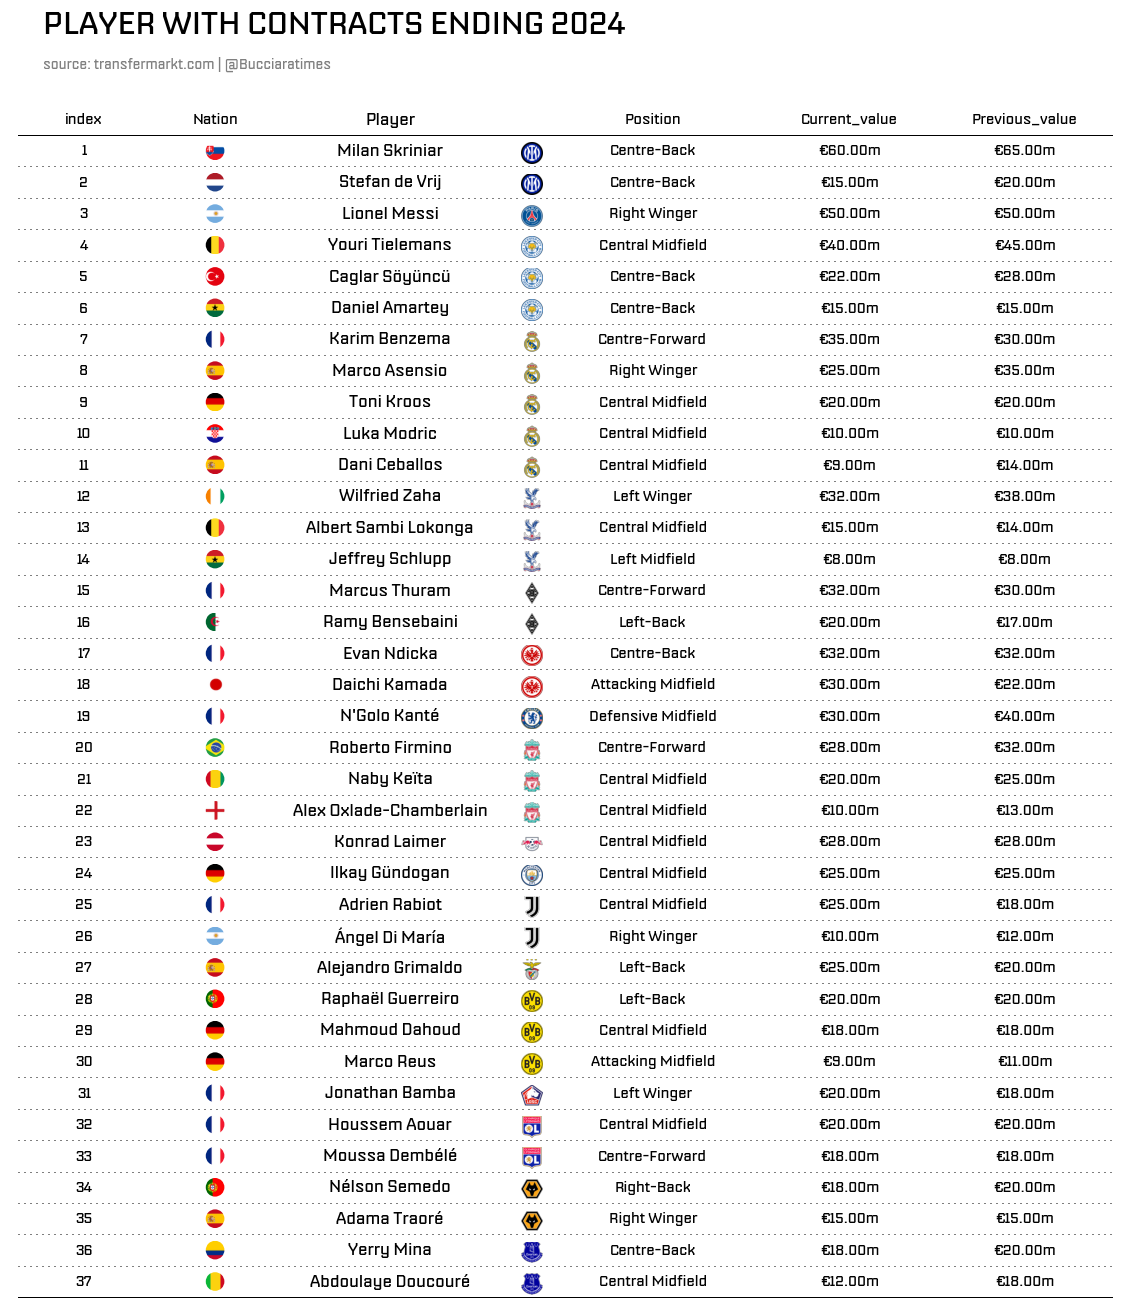

In [16]:
fig, ax = plt.subplots(figsize=(20, 22))

table = Table(
    data.iloc[:,:],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 15},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
)#.autoset_fontcolors(colnames=[rename_cols[5], rename_cols[6]])

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# Native data to norMLIzed data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for y in range(len(data)):
    x = 0
    team_id = data['Squad_id'].iloc[y]
    ax_coords = DC_to_NFC([x + 1.15, y + .95])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.015, 0.015], anchor = "W")
    try:
        club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")) #.convert("LA")
    except urllib.error.HTTPError as e:
        continue
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")
    
fig_text(
    x=0.15, y=.92, 
    s='PLAYER WITH CONTRACTS ENDING 2024',
    va='bottom', ha='left',
    fontsize=32, color='#000000', fontproperties=font_prop, fontweight='bold'
)
fig_text(
	x=0.15, y=.9, 
    s='source: transfermarkt.com | @Bucciaratimes',
	va='bottom', ha='left',
	fontsize=14, color='gray', fontproperties=font_prop
)

fig.savefig("/work/output/table51_1.png", facecolor=ax.get_facecolor(), dpi=200)

In [ ]:
urls = [
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2021",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2020",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2019",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2018",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2017",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2016",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2015",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2014",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2013",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2012",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2011",
#     "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2010"
]
dfs = []
for i,url in enumerate(urls):
    page = requests.get(url, headers={'User-Agent': 'Custom'})
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find(class_="grid-view", id="yw1")
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) 
    df = pd.DataFrame(data)
    df = df[df.columns[0:6]] 
    df.columns = ["club","squad","ave_age","foreign_players","ave_mkt_value","total_mkt_value"]
    try:
        season = urls[i].split("=")[1]
    except:
        season = "2022"
    df["season"] = season
    dfs.append(df)

In [ ]:
urls = [
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2021&saison_id_bis=2021&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2020&saison_id_bis=2020&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2019&saison_id_bis=2019&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2018&saison_id_bis=2018&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2017&saison_id_bis=2017&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2016&saison_id_bis=2016&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2015&saison_id_bis=2015&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0"  
]
dfs = []
season = 2022
for i,url in enumerate(urls):
    page = requests.get(url, headers={'User-Agent': 'Custom'})
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find(class_="grid-view", id="yw1")
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) 
    df = pd.DataFrame(data)
    df = df[df.columns[0:7]] 
    df.columns = ["idx","club","expenditure","arrivals","income","departures","balance"]
    df.drop(columns=["idx"],inplace=True)
    df["season"] = season
    season -= 1
    dfs.append(df)

In [ ]:
df = pd.concat(dfs)
df.sort_values(by="season",inplace=True)
df

In [43]:
cols= ["expenditure", "income", "balance"]
for col in cols:
    if col == "expenditure":
        df[col]= df[col].str.replace('.', '') \
                    .str.replace("-","0") \
                    .str.replace('€', "-") \
                    .str.replace("m","0000") \
                    .str.replace("Th","000") \
                    .str.replace("bn","0000000") \
#                     .astype('float')
    else:
        df[col]= df[col].str.replace('.', '') \
                    .str.lstrip('€') \
                    .str.replace("m","0000") \
                    .str.replace("Th","000") \
                    .str.replace("bn","0000000") \
#                     .astype('float')

<ipython-input-43-7c9cb69a4622>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]= df[col].str.replace('.', '') \
<ipython-input-43-7c9cb69a4622>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]= df[col].str.replace('.', '') \


In [44]:
team = "`"

val = df[df["club"]==team][cols[2]].values
balance_colors = []
for v in val:
    if float(v) < 0:
        balance_colors.append("red")
    else:
        balance_colors.append("#6FEDD6")    
print(val)
balance_colors

['33000000' '-34800000' '8400000' '-110100000' '61650000' '-7700000'
 '-53950000' '-19550000']


['#6FEDD6', 'red', '#6FEDD6', 'red', '#6FEDD6', 'red', 'red', 'red']

In [45]:
df[df["club"]==team]

,club,expenditure,arrivals,income,departures,balance,season
1,Atlético de Madrid,-119000000,35,152000000,24,33000000,2015
2,Atlético de Madrid,-78800000,35,44000000,21,-34800000,2016
1,Atlético de Madrid,-95600000,23,104000000,21,8400000,2017
0,Atlético de Madrid,-168000000,28,57900000,19,-110100000,2018
2,Atlético de Madrid,-247350000,25,309000000,20,61650000,2019
1,Atlético de Madrid,-91000000,22,83300000,17,-7700000,2020
0,Atlético de Madrid,-76700000,30,22750000,19,-53950000,2021
5,Atlético de Madrid,-26500000,27,6950000,19,-19550000,2022


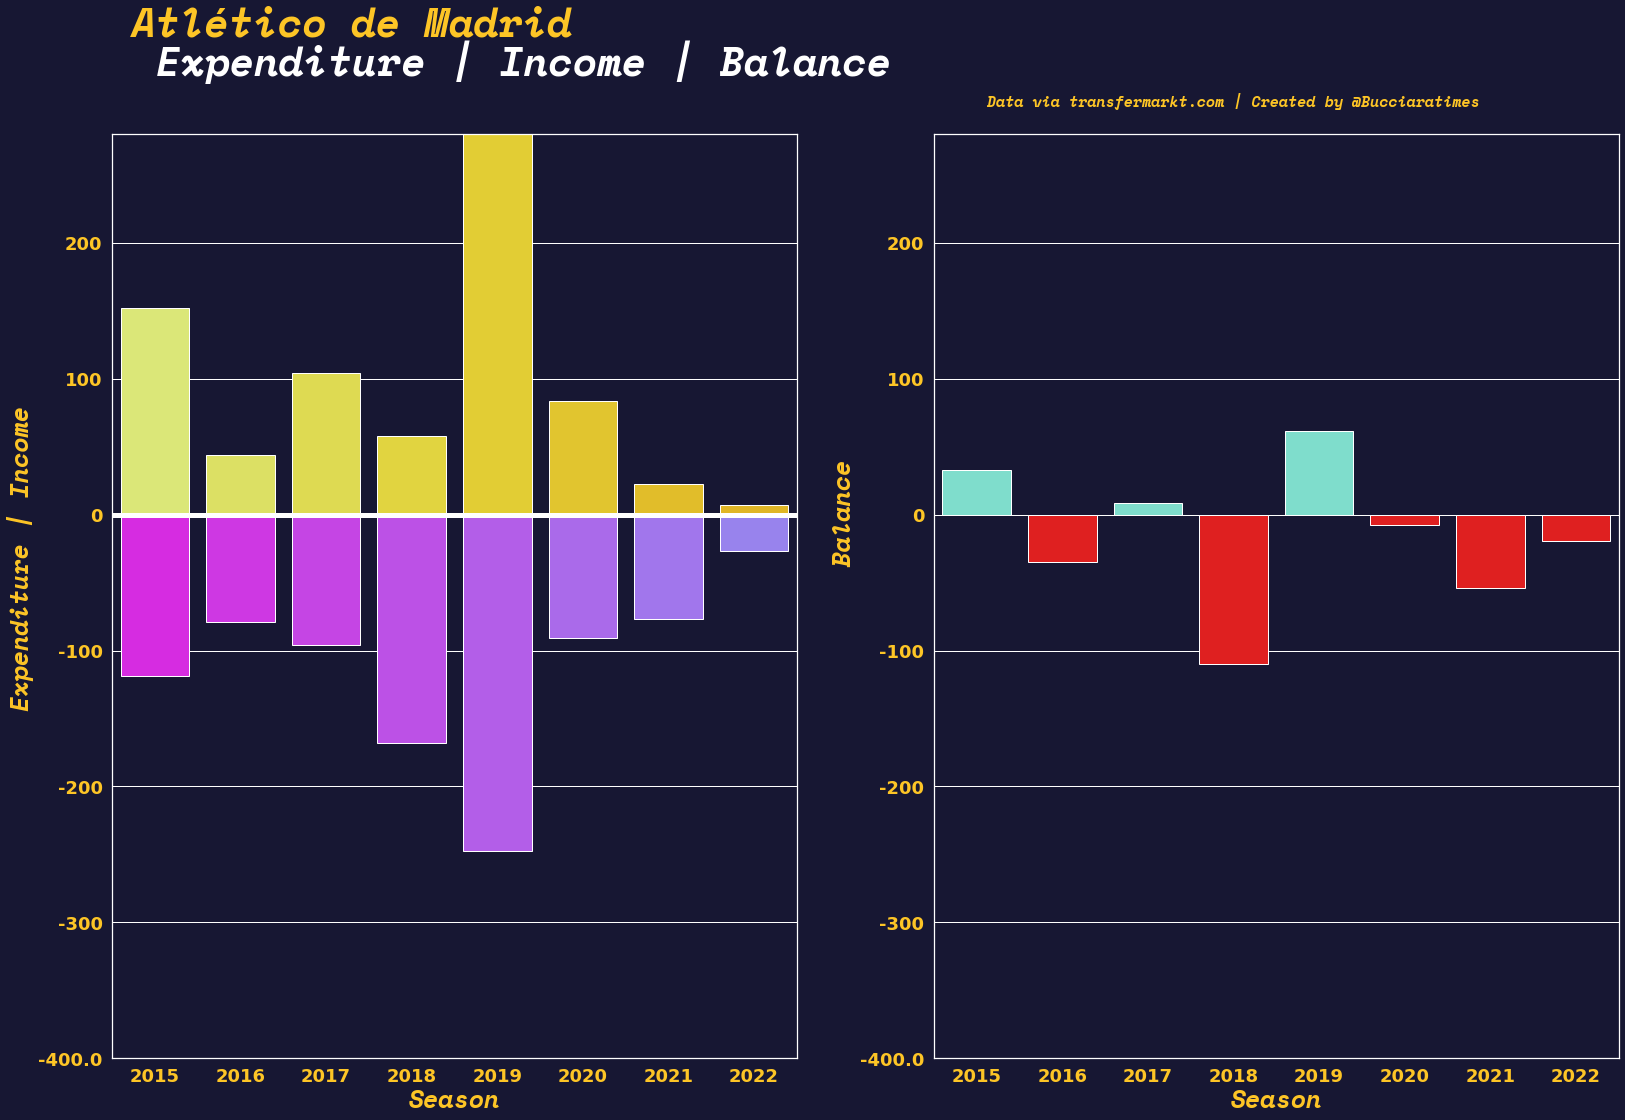

In [52]:
sns.set(style="darkgrid")
fig,axes = plt.subplots(1,2,figsize=(27,17))
fig_color = "#171733"
fig.set_facecolor(fig_color)
axes = axes.flatten()

axes[0].hlines(y=0, xmin=-50000000, xmax=150000000, colors="white", linewidth=5)
expenditure = sns.barplot(x="season", y=cols[0], orient="v", data=df[df["club"]==team], palette=sns.color_palette("cool_r", 17), ax=axes[0])
income = sns.barplot(x="season", y=cols[1], orient="v", data=df[df["club"]==team], palette=sns.color_palette("Wistia", 17),ax=axes[0])
balance = sns.barplot(x="season", y=cols[2], orient="v", data=df[df["club"]==team], palette=balance_colors,ax=axes[1])

axes[0].set_ylabel("     Expenditure | Income",fontweight='bold',fontsize=25,color="#fdc526",fontproperties=monoBFont.prop)   
axes[1].set_ylabel("           Balance",fontweight='bold',fontsize=25,color="#fdc526",fontproperties=monoBFont.prop)   

for i in range(len(axes)):
    axes[i].set_ylim((-400000000,280000000))
    axes[i].set_facecolor(fig_color)
    axes[i].set_xlabel("Season",fontsize=25,fontweight='bold',color="#fdc526",fontproperties=monoBFont.prop)
    axes[i].set_yticklabels([-400.  , -300, -200,  -100,   0,  100,  200, 300.  ])
    for xlabel,ylabel in zip(axes[i].get_xticklabels(),axes[i].get_yticklabels()):
        xlabel.set_fontsize(18)
        xlabel.set_color("#fdc526")
        xlabel.set_fontweight("bold")
        ylabel.set_fontsize(18)
        ylabel.set_color("#fdc526")
        ylabel.set_fontweight("bold")


fig_text(s=f"<{team}> \n {cols[0].title()} | {cols[1].title()} | {cols[2].title()}",
         x=axes[0].get_position().x0+.01,y=axes[0].get_position().y1+0.035,
         color="#ffffff",
         highlight_colors=["#fdc526"],
         highlight_weights=["bold"],
         highlight_styles=["italic"],
         fontsize=40,
         fontproperties=monoBFont.prop,fig=fig)

fig_text(s=f"<Data via transfermarkt.com | Created by @Bucciaratimes>",
         x=axes[0].get_position().x0+0.45,y=axes[0].get_position().y1+0.02,
         color="#f8f8f8",
         highlight_colors=["#fdc526"],
         highlight_weights=["bold"],
         highlight_styles=["italic"],
         fontsize=15,
         fontproperties=monoBFont.prop,fig=fig)

plt.savefig(f'/work/output/fee_{team}.png', dpi=300, bbox_inches="tight")

In [27]:

axes[0].set_yticklabels(np.linspace(-400,280,8))

[Text(0, -400000000.0, '-400.0'),
 Text(0, -300000000.0, '-302.8571428571429'),
 Text(0, -200000000.0, '-205.71428571428572'),
 Text(0, -100000000.0, '-108.57142857142856'),
 Text(0, 0.0, '-11.428571428571445'),
 Text(0, 100000000.0, '85.71428571428567'),
 Text(0, 200000000.0, '182.8571428571429'),
 Text(0, 300000000.0, '280.0')]

In [49]:
np.round(np.linspace(-400,320,8),2)

array([-400.  , -297.14, -194.29,  -91.43,   11.43,  114.29,  217.14,
        320.  ])

[-400.0, -300, -200, -100, 0, 100, 200, 300.0]

In [71]:
cols = [
    'Player',
    'Nation',
    'Pos',
    'Squad',
    'Age',
    'Born',
    'MP_Playing Time',
    'Starts_Playing Time',
    'Min_Playing Time',
    '90s_Playing Time',
    'Gls_Performance',
    'Ast_Performance',
    'G+A_Performance',
    'G-PK_Performance',
    'PK_Performance',
    'PKatt_Performance',
    'CrdY_Performance',
    'CrdR_Performance',
    'xG_Expected',
    'npxG_Expected',
    'xAG_Expected',
    'npxG+xAG_Expected',
    'PrgC_Progression',
    'PrgP_Progression',
    'PrgR_Progression',
    'Gls_Per 90 Minutes',
    'Ast_Per 90 Minutes',
    'G+A_Per 90 Minutes',
    'G-PK_Per 90 Minutes',
    'G+A-PK_Per 90 Minutes',
    'xG_Per 90 Minutes',
    'xAG_Per 90 Minutes',
    'xG+xAG_Per 90 Minutes',
    'npxG_Per 90 Minutes',
    'npxG+xAG_Per 90 Minutes',
    '90s',
    'Touches_Touches',
    'Def Pen_Touches',
    'Def 3rd_Touches',
    'Mid 3rd_Touches',
    'Att 3rd_Touches',
    'Att Pen_Touches',
    'Live_Touches',
    'Att_Take-Ons',
    'Succ_Take-Ons',
    'Succ%_Take-Ons',
    'Tkld_Take-Ons',
    'Tkld%_Take-Ons',
    'Carries_Carries',
    'TotDist_Carries',
    'PrgDist_Carries',
    'PrgC_Carries',
    '1/3_Carries',
    'CPA_Carries',
    'Mis_Carries',
    'Dis_Carries',
    'Rec_Receiving',
    'PrgR_Receiving',
    'SCA_SCA',
    'SCA90_SCA',
    'PassLive_SCA Types',
    'PassDead_SCA Types',
    'TO_SCA Types',
    'Sh_SCA Types',
    'Fld_SCA Types',
    'Def_SCA Types',
    'GCA_GCA',
    'GCA90_GCA',
    'PassLive_GCA Types',
    'PassDead_GCA Types',
    'TO_GCA Types',
    'Sh_GCA Types',
    'Fld_GCA Types',
    'Def_GCA Types',
    'Cmp_Total',
    'Att_Total',
    'Cmp%_Total',
    'TotDist_Total',
    'PrgDist_Total',
    'Cmp_Short',
    'Att_Short',
    'Cmp%_Short',
    'Cmp_Medium',
    'Att_Medium',
    'Cmp%_Medium',
    'Cmp_Long',
    'Att_Long',
    'Cmp%_Long',
    'Ast',
    'xAG',
    'xA',
    'A-xAG',
    'KP',
    '1/3',
    'PPA',
    'CrsPA',
    'PrgP',
    'Gls_Standard',
    'Sh_Standard',
    'SoT_Standard',
    'SoT%_Standard',
    'Sh/90_Standard',
    'SoT/90_Standard',
    'G/Sh_Standard',
    'G/SoT_Standard',
    'Dist_Standard',
    'FK_Standard',
    'PK_Standard',
    'PKatt_Standard',
    'npxG/Sh_Expected',
    'G-xG_Expected',
    'np:G-xG_Expected',
    'Att',
    'Live_Pass Types',
    'Dead_Pass Types',
    'FK_Pass Types',
    'TB_Pass Types',
    'Sw_Pass Types',
    'Crs_Pass Types',
    'TI_Pass Types',
    'CK_Pass Types',
    'In_Corner Kicks',
    'Out_Corner Kicks',
    'Str_Corner Kicks',
    'Cmp_Outcomes',
    'Off_Outcomes',
    'Blocks_Outcomes',
    '2CrdY_Performance',
    'Fls_Performance',
    'Fld_Performance',
    'Off_Performance',
    'Crs_Performance',
    'Int_Performance',
    'TklW_Performance',
    'PKwon_Performance',
    'PKcon_Performance',
    'OG_Performance',
    'Recov_Performance',
    'Won_Aerial Duels',
    'Lost_Aerial Duels',
    'Won%_Aerial Duels'
]

rename_cols = [
    'Player',
    'Nation',
    'Pos',
    'Squad',
    'Age',
    'Born',
    'MP Playing Time',
    'Starts',
    'Min Playing Time',
    '90s Playing Time',
    'Goal',
    'Assist',
    'Goal+Assist',
    'Goal-PK',
    'PK',
    'PK Attempt',
    'Yellow Card',
    'Red Card',
    'xG',
    'npxG',
    'xA',
    'npxG+xA',
    'Progressive Carry',
    'Progressive Pass',
    'Progressive Receive',
    'Goal Per90',
    'Assist Per90',
    'G+A Per90',
    'G-PK Per90',
    'G+A-PK Per90',
    'xG Per90',
    'xA Per90',
    'xG+xA Per90',
    'npxG Per90',
    'npxG+xA Per90',
    '90s',
    'Touches',
    'Def-Pen\nTouch',
    'Def-3rd\nTouch',
    'Mid-3rd\nTouch',
    'Att-3rd\nTouch',
    'Att-Pen\nTouch',
    'Live Touch',
    'Dribble Attempt',
    'Successful\nDribble',
    'Successful%\nDribble',
    'Tackled\nDribble',
    'Tackled%\nDribble',
    'Carries',
    'Total-Distance\nCarries',
    'Progressive-Distance\nCarries',
    'Progressive\nCarries',
    '1/3 Carries',
    'Pena Carries',
    'Miscontrol',
    'Ball Lost',
    'Pass Receiving',
    'Progressive-Pass\nReceiving',
    'Shot Create',
    'Shot Create90',
    'Shot Create\nBy PassLive',
    'Shot Create\nBy PassDead',
    'Shot Create\nBy Dribble',
    'Shot Create\nBy Shot',
    'Shot Create\nBy Fouls',
    'Shot Create\nBy Deffense',
    'Goal Create',
    'Goal Create90',
    'Goal Create\nBy PassLive',
    'Goal Create\nBy PassDead',
    'Goal Create\nBy Dribble',
    'Goal Create\nBy Shot',
    'Goal Create\nBy Fouls',
    'Goal Create\nBy Deffense',
    'Pass Complete',
    'Pass Attempt',
    'Pass Complete%',
    'Pass Total Distance',
    'Progressive-Pass\nTotal Distance',
    'Short-Pass\nComplete',
    'Short-Pass\nAttempt',
    'Short-Pass\nComplete%',
    'Medium-Pass\nComplete',
    'Medium-Pass\nAttempt',
    'Medium-Pass\nComplete%',
    'Long-Pass\nComplete',
    'Long-Pass\nAttempt',
    'Long-Pass\nComplete%',
    'Assist',
    'xAG',
    'xA',
    'A-xAG',
    'KP',
    '1/3',
    'PPA',
    'CrsPA',
    'PrgP',
    'Gls_Standard',
    'Sh_Standard',
    'SoT_Standard',
    'SoT%_Standard',
    'Sh/90_Standard',
    'SoT/90_Standard',
    'G/Sh_Standard',
    'G/SoT_Standard',
    'Dist_Standard',
    'FK_Standard',
    'PK_Standard',
    'PKatt_Standard',
    'npxG/Sh_Expected',
    'G-xG_Expected',
    'np:G-xG_Expected',
    'Att',
    'Live Pass',
    'Dead Pass',
    'FK Pass',
    'Throwgh Pass',
    'Switch Pass',
    'Cross',
    'TI Pass',
    'CK Pass',
    'In_Corner Kicks',
    'Out_Corner Kicks',
    'Str_Corner Kicks',
    'Cmp_Outcomes',
    'Off_Outcomes',
    'Blocks_Outcomes',
    '2CrdY_Performance',
    'Fls_Performance',
    'Fld_Performance',
    'Off_Performance',
    'Crs_Performance',
    'Int_Performance',
    'TklW_Performance',
    'PKwon_Performance',
    'PKcon_Performance',
    'OG_Performance',
    'Recov_Performance',
    'Won_Aerial Duels',
    'Lost_Aerial Duels',
    'Won%_Aerial Duels'
]



In [73]:
dict(zip(cols,rename_cols))

{'Player': 'Player',
 'Nation': 'Nation',
 'Pos': 'Pos',
 'Squad': 'Squad',
 'Age': 'Age',
 'Born': 'Born',
 'MP_Playing Time': 'MP Playing Time',
 'Starts_Playing Time': 'Starts',
 'Min_Playing Time': 'Min Playing Time',
 '90s_Playing Time': '90s Playing Time',
 'Gls_Performance': 'Goal',
 'Ast_Performance': 'Assist',
 'G+A_Performance': 'Goal+Assist',
 'G-PK_Performance': 'Goal-PK',
 'PK_Performance': 'PK',
 'PKatt_Performance': 'PK Attempt',
 'CrdY_Performance': 'Yellow Card',
 'CrdR_Performance': 'Red Card',
 'xG_Expected': 'xG',
 'npxG_Expected': 'npxG',
 'xAG_Expected': 'xA',
 'npxG+xAG_Expected': 'npxG+xA',
 'PrgC_Progression': 'Progressive Carry',
 'PrgP_Progression': 'Progressive Pass',
 'PrgR_Progression': 'Progressive Receive',
 'Gls_Per 90 Minutes': 'Goal Per90',
 'Ast_Per 90 Minutes': 'Assist Per90',
 'G+A_Per 90 Minutes': 'G+A Per90',
 'G-PK_Per 90 Minutes': 'G-PK Per90',
 'G+A-PK_Per 90 Minutes': 'G+A-PK Per90',
 'xG_Per 90 Minutes': 'xG Per90',
 'xAG_Per 90 Minutes': 'x